In this project, I will assume that I need to provide advice to a website provider who is looking for tools to automatically label images provided by end users. Recommendations to management about image classification will maximize accuracy over processing time. 

To determine a recommendation, I will use 1000 images of cats and 1000 images of dogs at two resolutions (64x64) and (128x128). This will be the basis to employ a 2x2 factorial design with resolution and color/grayscale as the two experimental factors. To keep this simple, I will not modify elements of the models (e.g. layers, filters, etc.), but keep everything constant as to not confound the experient. The results seen below will reveal that simple images (low resolution and grayscale) work better for the model.


In [1]:
# starting with code from run-cats-dogs-jump-start-dnn-v002.py
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# set-up needed modules
import os, random
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix 
from matplotlib import pyplot as plt 
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

RANDOM_SEED = 9999

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

#CatsDogs Old dimensions
height = 64
width = 64   
    

# Read in cats and dogs files to create training data
# used the output from run-cats-dogs-data-prep-v001.py
cats_1000_64_64_1 = np.load('cats_dogs_64-128/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('cats_dogs_64-128/dogs_1000_64_64_1.npy')

cats_1000_64_64_3 = np.load('cats_dogs_64-128/cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('cats_dogs_64-128/dogs_1000_64_64_3.npy')

cats_1000_128_128_1 = np.load('cats_dogs_64-128/cats_1000_128_128_1.npy')
dogs_1000_128_128_1 = np.load('cats_dogs_64-128/dogs_1000_128_128_1.npy')

cats_1000_128_128_3 = np.load('cats_dogs_64-128/cats_1000_128_128_3.npy')
dogs_1000_128_128_3 = np.load('cats_dogs_64-128/dogs_1000_128_128_3.npy')


Using TensorFlow backend.


In [2]:
#review shaoes of the loaded data
dogs_1000_128_128_3.shape

(1000, 128, 128, 3)

In [ ]:
#get an idea of the images were dealing with
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])

show_grayscale_image(cats_1000_64_64_3[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_3[0,:,:,0])

show_grayscale_image(cats_1000_128_128_1[0,:,:,0])
show_grayscale_image(dogs_1000_128_128_1[0,:,:,0])

show_grayscale_image(cats_1000_128_128_3[0,:,:,0])
show_grayscale_image(dogs_1000_128_128_3[0,:,:,0])

Ran cell, but deleted results to save space.

In [4]:
# bring the cats and dogs together
# Stack the numpy arrays for the inputs
X_cat_dog64_1 = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 

X_cat_dog64_3 = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 

X_cat_dog128_1 = np.concatenate((cats_1000_128_128_1, dogs_1000_128_128_1), axis = 0) 

X_cat_dog128_3 = np.concatenate((cats_1000_128_128_3, dogs_1000_128_128_3), axis = 0) 


In [5]:
#Check to see the arrays have been brought together
X_cat_dog64_1.shape
X_cat_dog64_3.shape
X_cat_dog128_1.shape
X_cat_dog128_3.shape

(2000, 128, 128, 3)

In [ ]:
# select ome cat and one dog image randomly to ensure
# data is brought together
show_grayscale_image(X_cat_dog64_1[900,:,:,0])
show_grayscale_image(X_cat_dog64_1[1104,:,:,0])

Ran cell, but deleted results to save space.

In [7]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog64_1 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

y_cat_dog64_3 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

y_cat_dog128_1 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

y_cat_dog128_3 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)


In [8]:
#normalize the data
X_cat_dog64_1 *= 255.0/X_cat_dog64_1.max() 
X_cat_dog64_3 *= 255.0/X_cat_dog64_3.max() 
X_cat_dog128_1 *= 255.0/X_cat_dog128_1.max() 
X_cat_dog128_3 *= 255.0/X_cat_dog128_3.max() 

In [9]:
# Random splitting of the data in to training (80%) and test (20%)  
X_train64_1, X_test64_1, y_train64_1, y_test64_1 = \
    train_test_split(X_cat_dog64_1, y_cat_dog64_1, test_size=0.20, 
                     random_state = RANDOM_SEED)


In [10]:
#train, val, test set will be 60%, 20%, 20% of the dataset respectively  
X_train64_1, X_val64_1, y_train64_1, y_val64_1 = \
    train_test_split(X_train64_1, y_train64_1, test_size=0.25, 
                     random_state = RANDOM_SEED)

In [11]:
X_test64_1.shape

(400, 64, 64, 1)

Run CNN for (64x64) grayscale photos (1 channels)

In [12]:
# Stop training when val_loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

In [13]:
# stack of 3 convolution layers with a ReLU activation
# followed by max-pooling layers
model64_1 = Sequential()
# 1: Convolution layer with 32 filters, each 3x3x3
model64_1.add(Conv2D(34, (3, 3), input_shape=(64, 64, 1)))
model64_1.add(Activation('relu'))
model64_1.add(MaxPooling2D(pool_size=(2, 2)))
# 2: Convolution layer with 32 filters, each 3x3x3
model64_1.add(Conv2D(34, (3, 3)))
model64_1.add(Activation('relu'))
model64_1.add(MaxPooling2D(pool_size=(2, 2)))
# 3: Convolution layer with 64 filters, each 3x3x3
model64_1.add(Conv2D(64, (3, 3)))
model64_1.add(Activation('relu'))
model64_1.add(MaxPooling2D(pool_size=(2, 2)))

# add two fully-connected layers
# sigmoid activation for a binary classification
# binary_crossentropy loss to train model.

model64_1.add(Flatten()) 
model64_1.add(Dense(64))
model64_1.add(Activation('relu'))
model64_1.add(Dropout(0.5))
model64_1.add(Dense(1))
model64_1.add(Activation('sigmoid'))

model64_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [14]:
start_time64_1 = time.clock()
trained_model64_1 = model64_1.fit(X_train64_1, y_train64_1, epochs=25, 
                                  batch_size=100,validation_data= (X_val64_1,y_val64_1),
                                  callbacks= [early_stopping])
end_time64_1 = time.clock()
runtime64_1 = end_time64_1 - start_time64_1

Train on 1200 samples, validate on 400 samples
Epoch 1/25
1200/1200 [==============================] - 16s 13ms/step - loss: 6.3981 - acc: 0.5233 - val_loss: 7.3328 - val_acc: 0.4950
Epoch 2/25
1200/1200 [==============================] - 15s 12ms/step - loss: 1.3873 - acc: 0.5075 - val_loss: 0.7272 - val_acc: 0.5225
Epoch 3/25
1200/1200 [==============================] - 15s 13ms/step - loss: 0.6965 - acc: 0.5392 - val_loss: 0.6915 - val_acc: 0.5375
Epoch 4/25
1200/1200 [==============================] - 15s 13ms/step - loss: 0.6977 - acc: 0.5825 - val_loss: 0.7201 - val_acc: 0.5250
Epoch 5/25
1200/1200 [==============================] - 8s 7ms/step - loss: 0.7073 - acc: 0.5575 - val_loss: 0.7168 - val_acc: 0.5025
Epoch 6/25
1200/1200 [==============================] - 13s 11ms/step - loss: 0.6830 - acc: 0.5758 - val_loss: 0.6877 - val_acc: 0.6075
Epoch 7/25
1200/1200 [==============================] - 15s 12ms/step - loss: 0.6497 - acc: 0.6108 - val_loss: 0.7003 - val_acc: 0.5650
Epo

In [59]:
#make predictions on test data and assess accuracy
#get F1 score
prediction64_1 = model64_1.predict(X_test64_1)
f164_1 = f1_score(y_test64_1, prediction64_1 > 0.5)
acc64_1 = accuracy_score(y_test64_1, prediction64_1 > 0.5)
acc64_1 = (acc64_1*100)
(f164_1, acc64_1)

(0.6176470588235293, 61.0)

Re-run process for (64x64) color photos (3 channels)


In [16]:
# Random splitting of the data in to training (80%) and test (20%)  
X_train64_3, X_test64_3, y_train64_3, y_test64_3 = \
    train_test_split(X_cat_dog64_3, y_cat_dog64_3, test_size=0.20, 
                     random_state = RANDOM_SEED)


In [17]:
#train, validation, test set will be 60%, 20%, 20% of the dataset respectively 
X_train64_3, X_val64_3, y_train64_3, y_val64_3 = \
    train_test_split(X_train64_3, y_train64_3, test_size=0.25, 
                     random_state = RANDOM_SEED)

In [18]:
# stack of 3 convolution layers with a ReLU activation
# followed by max-pooling layers
model64_3 = Sequential()
# 1: Convolution layer with 32 filters, each 3x3x3
model64_3.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model64_3.add(Activation('relu'))
model64_3.add(MaxPooling2D(pool_size=(2, 2)))
# 2: Convolution layer with 32 filters, each 3x3x3
model64_3.add(Conv2D(32, (3, 3)))
model64_3.add(Activation('relu'))
model64_3.add(MaxPooling2D(pool_size=(2, 2)))
# 1: Convolution layer with 64 filters, each 3x3x3
model64_3.add(Conv2D(64, (3, 3)))
model64_3.add(Activation('relu'))
model64_3.add(MaxPooling2D(pool_size=(2, 2)))

# add two fully-connected layers
# sigmoid activation for a binary classification
# binary_crossentropy loss to train model

model64_3.add(Flatten())
model64_3.add(Dense(64))
model64_3.add(Activation('relu'))
model64_3.add(Dropout(0.5))
model64_3.add(Dense(1))
model64_3.add(Activation('sigmoid'))

model64_3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
#measure the processing time
start_time64_3 = time.clock()
trained_model64_3 = model64_3.fit(X_train64_3, y_train64_3, epochs=25, 
                                  batch_size=100,validation_data= (X_val64_3,y_val64_3),
                                  callbacks= [early_stopping])
end_time64_3 = time.clock()
runtime64_3 = end_time64_3 - start_time64_3

Train on 1200 samples, validate on 400 samples
Epoch 1/25
1200/1200 [==============================] - 15s 12ms/step - loss: 7.2494 - acc: 0.5000 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 2/25
1200/1200 [==============================] - 15s 12ms/step - loss: 2.6286 - acc: 0.5325 - val_loss: 0.6978 - val_acc: 0.5350
Epoch 3/25
1200/1200 [==============================] - 14s 12ms/step - loss: 0.6993 - acc: 0.5608 - val_loss: 0.6784 - val_acc: 0.5925
Epoch 4/25
1200/1200 [==============================] - 14s 12ms/step - loss: 0.6710 - acc: 0.5917 - val_loss: 0.7098 - val_acc: 0.5175
Epoch 5/25
1200/1200 [==============================] - 14s 11ms/step - loss: 0.6638 - acc: 0.6183 - val_loss: 0.6725 - val_acc: 0.6150
Epoch 6/25
1200/1200 [==============================] - 14s 11ms/step - loss: 0.6673 - acc: 0.5908 - val_loss: 0.7111 - val_acc: 0.5750
Epoch 7/25
1200/1200 [==============================] - 14s 11ms/step - loss: 0.6650 - acc: 0.6108 - val_loss: 0.7912 - val_acc: 0.5450
E

In [47]:
#make predictions on test data and assess accuracy
prediction64_3 = model64_3.predict(X_test64_3)
acc64_3 = accuracy_score(y_test64_3, prediction64_3 > 0.5)
acc64_3 = (acc64_3 *100)

Re-run process for (128x128) grayscale photos (1 channel)


In [21]:
# Random splitting of the data in to training (80%) and test (20%)  
X_train128_1, X_test128_1, y_train128_1, y_test128_1 = \
    train_test_split(X_cat_dog128_1, y_cat_dog128_1, test_size=0.20, 
                     random_state = RANDOM_SEED)


In [22]:
#train, val, test set will be 60%, 20%, 20% of the dataset respectively 
X_train128_1, X_val128_1, y_train128_1, y_val128_1 = \
    train_test_split(X_train128_1, y_train128_1, test_size=0.25, 
                     random_state = RANDOM_SEED)

In [23]:
model128_1 = Sequential()

# stack of 3 convolution layers with a ReLU activation
# followed by max-pooling layers

# 1: Convolution layer with 32 filters, each 3x3x3
model128_1.add(Conv2D(32, (3, 3), input_shape=(128, 128, 1)))
model128_1.add(Activation('relu'))
model128_1.add(MaxPooling2D(pool_size=(2, 2)))

# 2: Convolution layer with 32 filters, each 3x3x3
model128_1.add(Conv2D(32, (3, 3)))
model128_1.add(Activation('relu'))
model128_1.add(MaxPooling2D(pool_size=(2, 2)))

# 3: Convolution layer with 64 filters, each 3x3x3
model128_1.add(Conv2D(64, (3, 3)))
model128_1.add(Activation('relu'))
model128_1.add(MaxPooling2D(pool_size=(2, 2)))

# add two fully-connected layers
# sigmoid activation for a binary classification
# binary_crossentropy loss to train model

model128_1.add(Flatten()) 
model128_1.add(Dense(64))
model128_1.add(Activation('relu'))
model128_1.add(Dropout(0.5))
model128_1.add(Dense(1))
model128_1.add(Activation('sigmoid'))

model128_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [24]:
#measure the processing time
start_time128_1 = time.clock()
trained_model128_1 = model128_1.fit(X_train128_1, y_train128_1, epochs=25, 
                                  batch_size=100,validation_data= (X_val128_1,y_val128_1),
                                   callbacks= [early_stopping])
end_time128_1 = time.clock()
runtime128_1 = end_time128_1 - start_time128_1

Train on 1200 samples, validate on 400 samples
Epoch 1/25
1200/1200 [==============================] - 54s 45ms/step - loss: 8.0738 - acc: 0.4883 - val_loss: 7.8915 - val_acc: 0.5050
Epoch 2/25
1200/1200 [==============================] - 51s 42ms/step - loss: 7.8915 - acc: 0.5050 - val_loss: 7.8915 - val_acc: 0.5050
Epoch 3/25
1200/1200 [==============================] - 51s 43ms/step - loss: 7.8915 - acc: 0.5050 - val_loss: 7.8915 - val_acc: 0.5050
Epoch 4/25
1200/1200 [==============================] - 50s 42ms/step - loss: 7.8915 - acc: 0.5050 - val_loss: 7.8915 - val_acc: 0.5050
Epoch 5/25
1200/1200 [==============================] - 51s 42ms/step - loss: 7.8915 - acc: 0.5050 - val_loss: 7.8915 - val_acc: 0.5050
Epoch 6/25
1200/1200 [==============================] - 52s 43ms/step - loss: 7.7989 - acc: 0.5108 - val_loss: 7.8915 - val_acc: 0.5050
Epoch 00006: early stopping


In [49]:
#make predictions on test data and assess accuracy
prediction128_1 = model128_1.predict(X_test128_1)
acc128_1 = accuracy_score(y_test128_1, prediction128_1 > 0.5)
acc128_1 = (acc128_1 *100)

Re-run process for (128x128) color photos (3 channels)


In [26]:
# Random splitting of the data in to training (80%) and test (20%)  
X_train128_3, X_test128_3, y_train128_3, y_test128_3 = \
    train_test_split(X_cat_dog128_3, y_cat_dog128_3, test_size=0.20, 
                     random_state = RANDOM_SEED)


In [27]:
#train, val, test set will be 60%, 20%, 20% of the dataset respectively  
X_train128_3, X_val128_3, y_train128_3, y_val128_3 = \
    train_test_split(X_train128_3, y_train128_3, test_size=0.25, 
                     random_state = RANDOM_SEED)

In [28]:
# stack of 3 convolution layers with a ReLU activation
# followed by max-pooling layers
model128_3 = Sequential()
# 1: Convolution layer with 32 filters, each 3x3x3
model128_3.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model128_3.add(Activation('relu'))
model128_3.add(MaxPooling2D(pool_size=(2, 2)))
# 2: Convolution layer with 32 filters, each 3x3x3
model128_3.add(Conv2D(32, (3, 3)))
model128_3.add(Activation('relu'))
model128_3.add(MaxPooling2D(pool_size=(2, 2)))
# 3: Convolution layer with 64 filters, each 3x3x3
model128_3.add(Conv2D(64, (3, 3)))
model128_3.add(Activation('relu'))
model128_3.add(MaxPooling2D(pool_size=(2, 2)))

# add two fully-connected layers
# sigmoid activation for a binary classification
# binary_crossentropy loss to train model

model128_3.add(Flatten()) 
model128_3.add(Dense(64))
model128_3.add(Activation('relu'))
model128_3.add(Dropout(0.5))
model128_3.add(Dense(1))
model128_3.add(Activation('sigmoid'))

model128_3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
#measure the processing time
start_time128_3 = time.clock()
trained_model128_3 = model128_3.fit(X_train128_3, y_train128_3, epochs=25, 
                                  batch_size=100,validation_data= (X_val128_3,y_val128_3), 
                                callbacks= [early_stopping])
end_time128_3 = time.clock()
runtime128_3 = end_time128_3 - start_time128_3

Train on 1200 samples, validate on 400 samples
Epoch 1/25
1200/1200 [==============================] - 61s 51ms/step - loss: 7.9841 - acc: 0.5000 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 2/25
1200/1200 [==============================] - 61s 51ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 3/25
1200/1200 [==============================] - 59s 49ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 4/25
1200/1200 [==============================] - 61s 51ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 5/25
1200/1200 [==============================] - 60s 50ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 6/25
1200/1200 [==============================] - 62s 52ms/step - loss: 8.1396 - acc: 0.4950 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 00006: early stopping


In [50]:
#make predictions on test data and assess accuracy
prediction128_3 = model128_3.predict(X_test128_3)
acc128_3 = accuracy_score(y_test128_3, prediction128_3)
acc128_3 = (acc128_3 *100)

In [61]:
print ("\n64x64 grayscale Processing time (seconds): %f" % runtime64_1)
print ("\n64x64 color Processing time (seconds): %f" % runtime64_3)
print ("\n128x128 grayscale Processing time (seconds): %f" % runtime128_1)
print ("\n128x128 color Processing time (seconds): %f" % runtime128_3)
print ("\n64x64 grayscale Test Accuracy: %1.f%%" % acc64_1)
print ("\n64x64 color Test Accuracy: %1.f%%" % acc64_3)
print ("\n128x128 grayscale Test Accuracy: %1.f%%" % acc128_1)
print ("\n128x128 color Test Accuracy: %1.f%%" % acc128_3)


64x64 grayscale Processing time (seconds): 157.484248

64x64 color Processing time (seconds): 141.059158

128x128 grayscale Processing time (seconds): 309.712366

128x128 color Processing time (seconds): 364.464930

64x64 grayscale Test Accuracy: 61%

64x64 color Test Accuracy: 60%

128x128 grayscale Test Accuracy: 48%

128x128 color Test Accuracy: 52%




A summary table for the 2x2 experiment is seen below. The same CNN was leveraged for each experiment with the only changes occuring between resolution and color/grayscale so we can know what elements are impacting accuracy. The CNN inlcudes a stack of 3 convolution layers (2 with 32 filters and 1 with 64 filters) with a ReLU activation, followed by max-pooling layers.  It also includes 2 fully-connected layers with sigmoid activation for a binary classification and binary_crossentropy loss to train the model.

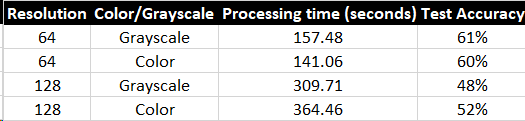

For this convolutional neural network, simple images work best. The team should not necessarily be stressed about needing high resolution, color images from user submissions to run a model, as this model works best with (64x64) grayscale images. If users do choose to submit (64x64) color photos, the model will predict similarly as accuracy does not really drop (61% accurate with grayscale images vs. 60% accurate with color images). This model also is pretty efficient, taking less time to run than other models leveraging higher resoltion images. 

In [43]:
#make predictions binary: 
# cats = 0 dogs = 1
prediction64_1[prediction64_1 > 0.5] = 1
prediction64_1[prediction64_1 <= 0.5] = 0

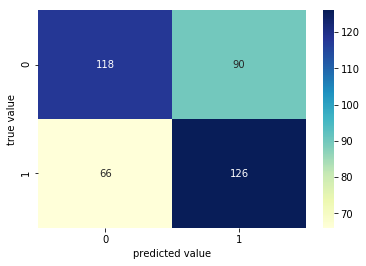

In [44]:
#Prediction of test set
conf_matrix = confusion_matrix(y_test64_1,prediction64_1)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

The better CNN model leveraging (64x64) grayscale photos confuses more dogs(1) as cats (0) than cats (0) as dogs (1). Further training and modification of hyperparameters should be pursued to continue to improve the accuracy of image classification. 